Calcualting the stellar wind

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from scipy.io.idl import readsav
from astropy import constants as const
from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
rates = Table.read('tables/pceb_fit_results_rates.csv')
rates

Target,Teff,e_Teff,logg,e_logg,si,si_e,c,c_e,o,o_e,s,s_e,mass,q,tdiff_si,tdiff_c,tdiff_o,tdiff_s,Fsi,Fsi_e,Fc,Fc_e,Fo,Fo_e,Fs,Fs_e,porb_min,spt,mass_est,rad_est,lum_est,lx,lxel,lexeu
str11,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64
V-UZ-SEX,17146,15,7.801,0.007,-7.08,0.03,-6.21,0.05,-6.44,0.07,-7.36,0.3,0.511,-16.343,-1.997,-2.272,-2.135,-2.272,336385.0913,15320.37649,2008822.103,152446.5769,1149357.541,122104.1368,379599.6727,172820.6755,860.0,M4,0.22,0.258,-2.51,5.56e+27,1.31e+27,4.21e+26
V-LM-COM,28878,1122,7.358,0.1,-6.96,0.04,-5.9,0.04,-5.63,0.0,-6.96,0.0,0.424,-15.4,-0.913,-1.069,-1.024,-1.069,265938.7946,19504.52052,1870193.033,137163.9607,4182154.821,0.0,434781.2289,0.0,373.0,M3,0.36,0.369,-1.79,-5.6e+28,0.0,0.0
WD-1339+606,37074,76,7.449,0.005,-7.88,0.4,-8.32,0.1,-8.05,0.4,-7.34,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356.0,M3,0.36,0.369,-1.79,-9e+28,0.0,0.0
WD-1504+546,21730,53,7.67,0.01,-7.13,0.2,-8.25,0.09,-8.15,0.3,-7.43,0.6,0.464,-15.894,-1.515,-1.609,-1.758,-1.609,252309.6261,76582.37196,10163.38924,1388.40783,24018.85112,10935.24372,179235.037,163201.1191,1340.0,M3,0.36,0.369,-1.79,9.26e+28,3.62e+28,3.74e+28
WD-2317+268,28403,19,7.585,0.005,-6.78,0.03,-5.82,0.03,-4.66,0.1,-6.65,0.2,0.452,-15.541,-1.068,-1.232,-1.195,-1.232,443153.5923,20179.70829,2521500.235,114820.5499,44583348.57,6765937.313,995504.8128,302149.8672,1140.0,M3,0.36,0.369,-1.79,-2.4e+28,0.0,0.0
WD-1436-216,22814,38,7.658,0.01,-7.19,0.05,-6.27,0.1,-5.92,0.4,-8.18,0.1,0.463,-15.83,-1.453,-1.548,-1.699,-1.548,220291.0386,16721.78698,975217.6868,148009.902,4117325.866,2499337.128,32024.76269,4860.434806,2910.0,M2,0.44,0.434,-1.54,5.07e+28,9.84e+26,7.8e+26
WD-1458+171,21406,4,7.445,0.0003,-6.19,0.3,-5.09,0.04,-5.96,0.0,-6.51,0.0,0.399,-15.65,-1.25,-1.344,-1.496,-1.344,1800481.797,819703.8918,12036313.03,730638.5581,3069072.482,0.0,1221455.993,0.0,237.0,M4,0.22,0.258,-2.51,3.7e+28,1.18e+28,8.42e+27
WD2257+162,22886,33,7.24,0.008,-7.38,0.05,-6.27,0.05,-8.03,0.5,-7.34,0.1,0.404,-15.587,-1.19,-1.288,-1.439,-1.288,118521.5178,8995.775491,818280.0127,62107.39973,26817.33484,20348.5671,185902.9555,28213.98152,464.0,M4.5,0.18,0.243,-2.84,0.0,0.0,0.0
WD2256+249,21488,17,7.73,0.006,-6.88,0.02,-5.76,0.02,-5.72,0.05,-7.39,0.2,0.49,-15.996,-1.622,-1.719,-1.862,-1.719,479304.9558,14557.21339,3378443.483,102608.4168,6858518.74,520467.5137,211398.0657,64162.43974,250.0,M4,0.22,0.258,-2.51,0.0,0.0,0.0


In [3]:
els = ['si', 'c', 'o', 's']
el_mass = [28.085, 12.011, 15.999, 32.06]
sol_frac = [6.649e-4, 2.365e-3,5.733e-3, 3.093e-4]

In [4]:
def find_v(a, Rrd, Mrd, Mwd, p):
    """
    velocity of the stellar wind at distance a
    """
    a, Rrd, Mrd, Mwd, p = a.to(u.m), Rrd.to(u.m), Mrd.to(u.kg), Mwd.to(u.kg), p.to(u.s)
    vorb = (2*np.pi/p) * a * (Mrd/(Mrd+Mwd)) #orbital velocity of wd
#     print('vorb=', vorb)
    vwind = ((2*const.G*Mrd)/Rrd)**0.5 #approximate as escape velocity
#     print('vwind=' , vwind)
    vrel = (vwind**2+vorb**2)**0.5
    return vrel

def mass_loss(mdot, Mwd, a, v): 
    """mass loss rate of mdwarf to produce an accretion rate mdot onto a white dwarf of mass Mwd at separation a"""
#     m_loss = (((2*a*Mrd)/(Rrd*Mwd))**2) * mdot
#     print(Mwd, Mrd)
    mdot, Mwd, a, v =  mdot.to(u.g/u.s), Mwd.to(u.kg), a.to(u.m), v.to(u.m/u.s)
#     print(v)
  #  v= 600000*u.m/u.s
#     print(a.to(u.Rsun))
   # print(v)
#     print (mdot, Mwd, a, v)
    scale = (v**4*a**2)/(const.G**2*Mwd**2)
#     print('scale=',scale)
    m_loss = mdot*scale
    return m_loss

def total_infer(mdot, el):
#     print(el)
    els = np.genfromtxt('solar_abd.tsv', names=True, delimiter='\t', dtype=None, encoding=None)
    mf = els['mass_fraction'][np.where(els['Atom_X']==el)][0]
    total_mdot = mdot/mf
    return total_mdot

def p_to_a(m1, m2, p):
    m1, m2, p = m1.to(u.kg), m2.to(u.kg), p.to(u.s)
    a = ((const.G*(m1+m2) * p**2)/(4*np.pi**2))**(1/3)
#     print(a.to(u.Rsun))
    return a
                                   
def find_wind(mdot, Mwd,p, Rrd, Mrd, el):
#     print(el)
#     print(mdot)
    a = p_to_a(Mwd, Mrd, p)
    v = find_v(a, Rrd, Mrd, Mwd, p)
    rate = mass_loss(mdot, Mwd, a, v)
#     print(rate)
#     print(rate)
    total = total_infer(rate, el.capitalize())
#     print(total)
    return(total)
                                   

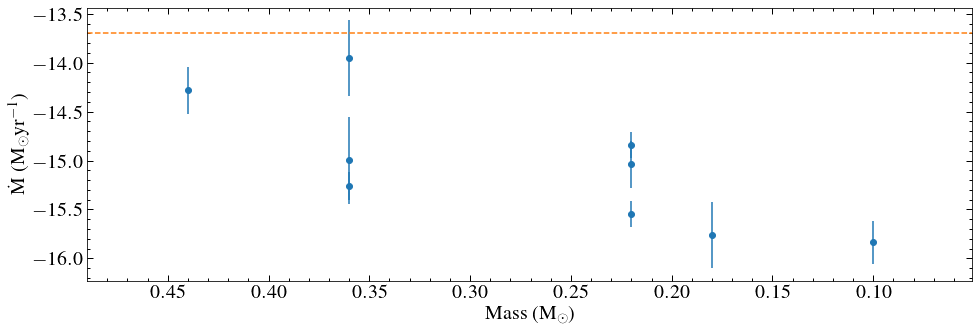

In [5]:
wind_names = []
wind_rates = []
wind_errors = []
masses = []
sptypes = [] 
for row in rates:
#     if row['Target'] == 'WD0710+741':
    if row['Teff'] < 30000:
        masses.append(row['mass_est'])
        sptypes.append(row['spt'])
        mdots = []
        for i, el in enumerate(els):
            if row['{}_e'.format(el)] > 0.0:
                acc = row['F{}'.format(el)]*(u.g/u.s)
                Mwd, Mrd = row['mass']*u.M_sun, row['mass_est']*u.M_sun
                Rrd = row['rad_est']*u.R_sun 
                p = row['porb_min']*u.min
#                 print(p)
                mdot = find_wind(acc, Mwd,p, Rrd, Mrd, el)
                mdots.append(mdot.value)
      #  print(mdots)
#         mdots = np.array(mdots)*u.g/u.s
     #   print(np.mean(mdots))
        wind_rates.append(np.mean(mdots))
        wind_errors.append(np.std(mdots))
        wind_names.append(row['Target'])

# print(wind_rates)
wind_rates = np.array(wind_rates)*(u.g/u.s).to(u.M_sun/u.yr)
wind_errors = np.array(wind_errors)*(u.g/u.s).to(u.M_sun/u.yr)

log_wind_rates = np.log10(wind_rates)
log_wind_errors = 0.434 * (wind_errors/wind_rates)
# print(np.log10(wind_rates))
masses= np.array(masses)

plt.errorbar(masses, log_wind_rates, yerr=log_wind_errors, marker='o', ls='none')
plt.xlim(0.49, 0.051)
plt.axhline(np.log10(2e-14), c='C1', ls='--')
plt.xlabel(r'Mass (M$_{\odot}$)')
plt.ylabel(r'\.M (M$_{\odot}$yr$^{-1}$)')
plt.tight_layout()
#  print(len(masses))
#print(masses)


In [6]:
rates_tab= np.genfromtxt('wind_measurements.csv', delimiter=',', dtype=None, encoding=None, names=True)

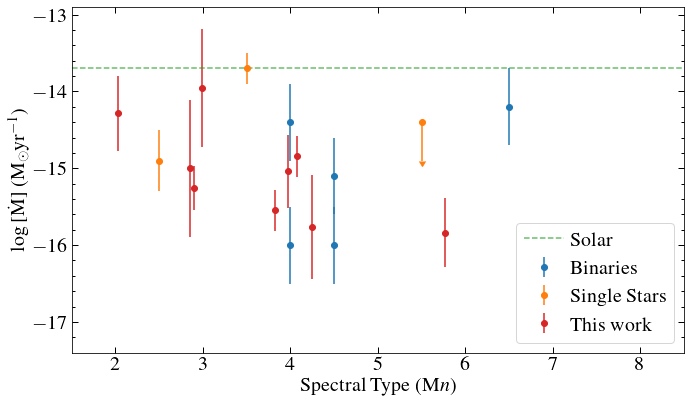

In [7]:
sol_n = 2e-14
sol = np.log10(2e-14)

# new_types = [4, 5, 3, 4.0, 4.5, 3.5, 2.5, 4.5, 3.0, 3.5, 5.0, 6, 4.0, 4.5]
# row_1 = [4, 5, 3, 4.5, 3.5, 2.5,  3.5, 6, 8]
# row_2 = [4.0, 4.5,3.0, 5.0,]
# row_3 = [4.0, 4.5]

data_m = rates_tab[rates_tab['e_mdot'] != 0]
data_u = rates_tab[rates_tab['e_mdot'] == 0]

fig, ax =plt.subplots(figsize=(10,6))
plt.errorbar(data_m['spn'][data_m['method'] =='pceb'], data_m['log_mdot'][data_m['method'] =='pceb'], 
             yerr= data_m['e_mdot'][data_m['method'] =='pceb'], marker='o', ls='none', label='Binaries')
plt.errorbar(data_m['spn'][data_m['method'] !='pceb'], data_m['log_mdot'][data_m['method'] !='pceb'], 
             yerr= data_m['e_mdot'][data_m['method'] !='pceb'], marker='o', ls='none', label='Single Stars')
plt.errorbar(data_u['spn'][data_u['method'] !='pceb'], data_u['log_mdot'][data_u['method'] !='pceb'], yerr=0.5, marker='o', ls='none', uplims=True, c='C1')

newtypes = [float(spt[1:]) for spt in sptypes]
plt.errorbar(newtypes+np.random.normal(0, 0.1, len(newtypes)), log_wind_rates, yerr=log_wind_errors*2, marker='o', ls='none', c='C3', label ='This work')


plt.xlabel('Spectral Type (M$n$)')
plt.ylabel('log\,[\.M] ($\mathrm{M}_{\odot}\mathrm{yr}^{-1}$)')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False,
    bottom=False)      # ticks along the bottom edge are off 
plt.xlim(1.5, 8.5)
plt.axhline(sol, ls='--', c='C2', alpha =0.7, label='Solar')
plt.ylim(-17.4, -12.9)
# plt.scatter(row_1, np.full(len(row_1), -13), marker='x', c='C3', label = 'New Systems')
# plt.scatter(row_2, np.full(len(row_2), -13.2), marker='x', c='C3')
# plt.scatter(row_3, np.full(len(row_3), -12.8), marker='x', c='C3')



plt.legend(frameon=True, loc=4)
plt.tight_layout()
# plt.savefig('plots/wind_sota_150.pdf', facecolor='w',dpi=150)
# plt.savefig('plots/wind_sota_150.png', facecolor='w',dpi=150)

In [8]:
[float(spt[1:]) for spt in sptypes]

[4.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.5, 4.0, 6.0]

In [9]:
# a[0].upper()

In [10]:
const.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

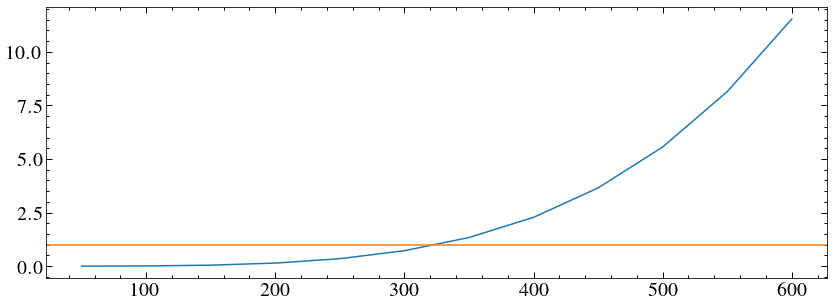

In [11]:

a= 0.7*u.Rsun
Mwd = 0.389*u.Msun
vs = np.arange(50, 601, 50)*u.km/u.s
scales = np.array([(v**4*a**2)/(const.G**2*Mwd**2) for v in vs])
plt.plot(vs, scales)
plt.axhline(1, c='C1')

Updating with new values from https://arxiv.org/pdf/2105.00019.pdf 

In [12]:
singles_tab = np.genfromtxt('wood21_v1.csv', delimiter=',', dtype=None, encoding=None, names=True)
print(len(singles_tab))
singles_tab = singles_tab[singles_tab['Ṁdot_Ṁdotsun_']!=0.0]
print(len(singles_tab))

17
15


In [13]:
singles_tab.dtype.names

('ID',
 'Star',
 'Spectral_Type',
 'sp_num',
 'd_pc',
 'VISM_km_s−1_',
 'θ_deg',
 'Ṁdot_Ṁdotsun_',
 'log_Lx',
 'Radius_Rsun_',
 'Mass_est')

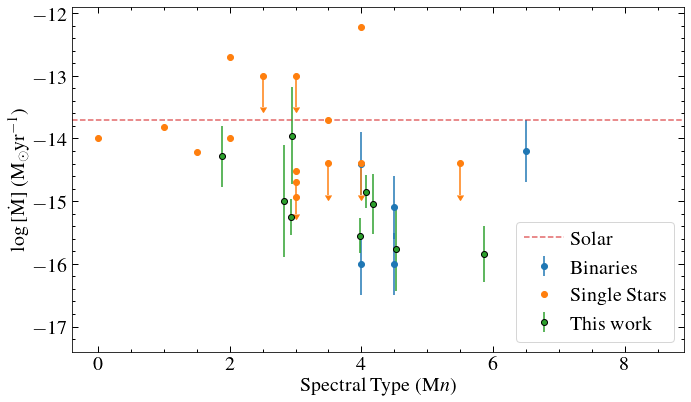

In [14]:
sol_n = 2e-14
sol = np.log10(2e-14)

# new_types = [4, 5, 3, 4.0, 4.5, 3.5, 2.5, 4.5, 3.0, 3.5, 5.0, 6, 4.0, 4.5]
# row_1 = [4, 5, 3, 4.5, 3.5, 2.5,  3.5, 6, 8]
# row_2 = [4.0, 4.5,3.0, 5.0,]
# row_3 = [4.0, 4.5]

data_m = rates_tab[rates_tab['e_mdot'] != 0]
data_u = rates_tab[rates_tab['e_mdot'] == 0]

fig, ax =plt.subplots(figsize=(10,6))
plt.errorbar(data_m['spn'][data_m['method'] =='pceb'], data_m['log_mdot'][data_m['method'] =='pceb'], 
             yerr= data_m['e_mdot'][data_m['method'] =='pceb'], marker='o', ls='none', label='Binaries')


# plt.errorbar(data_m['spn'][data_m['method'] !='pceb'], data_m['log_mdot'][data_m['method'] !='pceb'], 
#              yerr= data_m['e_mdot'][data_m['method'] !='pceb'], marker='o', ls='none', label='Single Stars')
# plt.errorbar(data_u['spn'][data_u['method'] !='pceb'], data_u['log_mdot'][data_u['method'] !='pceb'], yerr=0.5, marker='o', ls='none', uplims=True, c='C1')
sings = singles_tab[singles_tab['Ṁdot_Ṁdotsun_'] >0]
singups = singles_tab[singles_tab['Ṁdot_Ṁdotsun_'] <0]
plt.errorbar(sings['sp_num'],np.log10(sings['Ṁdot_Ṁdotsun_']*sol_n),label='Single Stars', marker='o',ls='none',c='C1')
plt.errorbar(singups['sp_num'],np.log10(abs(singups['Ṁdot_Ṁdotsun_'])*sol_n),yerr=0.5, uplims=True, marker='o',ls='none',c='C1')


newtypes = [float(spt[1:]) for spt in sptypes]
plt.errorbar(newtypes+np.random.normal(0, 0.1, len(newtypes)), log_wind_rates, yerr=log_wind_errors*2, marker='o', ls='none', c='C2', label ='This work', markeredgecolor='k')
# plt.errorbar(-1, -1, marker='o', ls='none', c='C2', label ='This work', markeredgecolor='k')


plt.xlabel('Spectral Type (M$n$)')
plt.ylabel('log\,[\.M] ($\mathrm{M}_{\odot}\mathrm{yr}^{-1}$)')
# ax.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='minor',      # both major and minor ticks are affected
#     top=False,
#     bottom=False)      # ticks along the bottom edge are off 
plt.xlim(-0.4, 8.9)
plt.axhline(sol, ls='--', c='C3', alpha =0.7, label='Solar')
plt.ylim(-17.4, -11.9)
# plt.scatter(row_1, np.full(len(row_1), -13), marker='x', c='C3', label = 'New Systems')
# plt.scatter(row_2, np.full(len(row_2), -13.2), marker='x', c='C3')
# plt.scatter(row_3, np.full(len(row_3), -12.8), marker='x', c='C3')



plt.legend(frameon=True, loc=4)
plt.tight_layout()
plt.savefig('plots/wind_sota_150.pdf', facecolor='w',dpi=150)
plt.savefig('plots/wind_sota_150.png', facecolor='w',dpi=150)

wd0137 plot for talk

In [15]:
# cpath = '/media/david/5tb_storage1/pceb_data/'
# cx = '{}ldlc04010_x1dsum.fits'.format(cpath)

# smooth=5
# data = fits.getdata(cx, 1)
# wc = np.array([], dtype=float)
# fc = np.array([], dtype=float)
# ec = np.array([], dtype=float)
# for dt in data[::-1]:
#     wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
#    # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
#     mask = (dq==0)
#     wi, fi, ei = wi[mask], fi[mask], ei[mask]
#     wc = np.concatenate((wc, wi))
#     fc = np.concatenate((fc, fi))
#     ec = np.concatenate((ec, ei))    

# fc = convolve(fc,Box1DKernel(smooth))
# ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# # plt.plot(wc, fc)

# fig, ax = plt.subplots(figsize=(10, 6))
# mask = (wc > 1140) & (wc < 1214) | (wc > 1217) &(wc < 1425) &(fc > 0)
# wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]
# plt.plot(wc1, fc1)

# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.xlim(1140, 1425)

# # axins = inset_axes(ax, width=3, height=2.5, loc = 2)
# # axins.plot(wc1, fc1)
# # axins.set_xlim(1331, 1339)
# # axins.set_ylim(0.05e-13,0.8e-13)
# # axins.set_yticklabels([],visible=False)


# plt.tight_layout()
# plt.savefig('plots/lm_com_cos.png', dpi=150,facecolor='w')

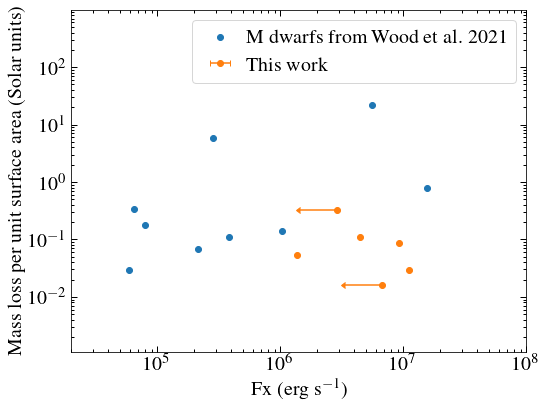

In [30]:
plt.figure(figsize=(8, 6))
mdotsur = singles_tab['Ṁdot_Ṁdotsun_']/(4*np.pi*singles_tab['Radius_Rsun_']**2)
fxsur = (10**singles_tab['log_Lx'])/(4*np.pi*(singles_tab['Radius_Rsun_']*u.Rsun.to(u.cm))**2)

plt.scatter(fxsur, mdotsur, label = 'M dwarfs from Wood et al. 2021')
plt.xscale('log')
plt.yscale('log')
        
line_init = models.PowerLaw1D(0.1,1e5,-0.77, fixed=dict(alpha=True))

for i, name in enumerate(wind_names):
    row = rates[np.where(rates['Target'] == name)[0][0]]
    if row['lx'] != 0:
        # lx = (abs(row['lx'])*(u.erg/u.s)).to(u.Lsun)
        lx = abs(row['lx'])
        # lstar = (10**row['lum_est'])*u.Lsun
        # rx = lx/lstar
        wind = wind_rates[i]/sol_n
        wind_sur = wind/(4*np.pi*row['rad_est']**2)
        lx_sur = lx/ (4*np.pi*(row['rad_est']*u.Rsun.to(u.cm))**2)
        if row['lx'] < 0:
            plt.errorbar(lx_sur, wind_sur, xerr=0.5*lx_sur, xuplims=True, marker='o', ls='none', c='C1', label = 'This work')
        else:
            plt.errorbar(lx_sur, wind_sur, marker='o', ls='none', c= 'C1')
        

# fitter = fitting.LevMarLSQFitter()

# line = fitter(line_init, fxsur, mdotsur)

# print(line)
# xline = np.arange(4000, 1e8, 1000)
# plt.plot(xline, line(xline))

# myline_init =  models.PowerLaw1D(0.1,1e5,-0.77)

# # myline = fitter(myline_init, fxsur, mdotsur)

# print(myline)
# # xline = np.arange(4000, 1e8, 1000)
# plt.plot(xline, myline(xline))


plt.xlabel('Fx (erg s$^{-1}$)')
plt.ylabel('Mass loss per unit surface area (Solar units)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=True)


plt.xlim(2e4, 1e8)
plt.ylim(1.1e-3, 9.9e2)



plt.tight_layout()

plt.savefig('plots/wind_v_fx_v1.png')

In [17]:
wind_rates

array([9.14966949e-16, 5.52426106e-16, 1.00168027e-15, 1.11479164e-14,
       5.20052350e-15, 1.42545626e-15, 1.72368052e-16, 2.82763080e-16,
       1.45262991e-16])